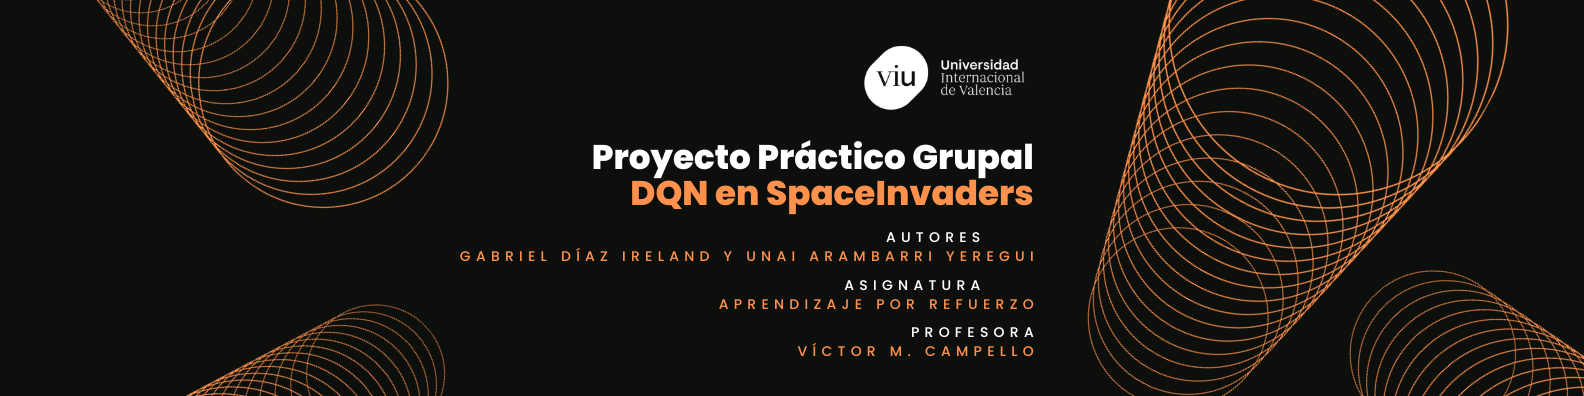

Para este proyecto, utilizamos las librerias de tensorflow y keras rl, probando en el camino a crear la arquitectura del modelo por clases con pytorch.

Al igual que el feedback de la asignatura de Matemáticas para la Inteligencia Artificial fue muy positivo ya que entendíamos en profundidad como utilizar las distintas técnicas que se usan en Inteligencia Artificial, diríamos que este proyecto a resultado ser mucho más pesado y dificil y que tenemos la sensación de que el aprendizaje ha sido menor.

Esto se debe principalmente a que las liberías de rl y tensorflow tienen problemas de compatibilidad, con los que hemos estado mas tiempo lidiando que realizando y diseñano el proyecto. También hemos tenido problemas de entrenamiento (por la capacidad de colab) y hasta que porfin el notebook ha corrido entero, hemos tenido que probar alrededor de 15-16 veces.

Por el resto, las clases nos han parecido buenas y la asignatura completa para entender el mundo de RL:

### Proyecto práctico

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _Space Invaders_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, una solución óptima será alcanzada cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

   1) Implementar la red neuronal que se usará en la solución
    
   2) Implementar las distintas piezas de la solución DQN
    
   3) Justificar la respuesta en relación a los resultados obtenidos

IMPORTANTE:

- Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.

- Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).

- Necesitaréis instalar `gymnasium[atari,accept-rom-license]`


#### Importar librerías

In [1]:
from google.colab import drive
import os

mount='/content/gdrive'
drive_root = mount + "/My Drive/03 - Máster en Inteligencia Artificial/8 - Aprendizaje por Refuerzo/Proyecto"

drive.mount(mount)
os.makedirs(drive_root, exist_ok=True)
%cd $drive_root

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/03 - Máster en Inteligencia Artificial/8 - Aprendizaje por Refuerzo/Proyecto


In [12]:
%pip install gym==0.17.3
%pip install git+https://github.com/Kojoley/atari-py.git
%pip install keras-rl2==1.0.5
%pip install tensorflow==2.8

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/Kojoley/atari-py.git to /tmp/pip-req-build-l4mlxktp
  Running command git clone --filter=blob:none --quiet https://github.com/Kojoley/atari-py.git /tmp/pip-req-build-l4mlxktp
  Resolved https://github.com/Kojoley/atari-py.git to commit 86a1e05c0a95e9e6233c3a413521fdb34ca8a089
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow==2.8 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.8
Note: you may need to restart the kernel to use updated packages.


In [38]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, MaxPooling2D, GlobalAveragePooling2D \
                                    ,LeakyReLU , BatchNormalization, Dropout
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

#### Configuración base

In [39]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [28]:
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
input_shape

(4, 84, 84)

In [29]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

## 1) Implementación de la red neuronal

In [30]:
model = Sequential()
if K.image_data_format() == 'channels_last':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_data_format() == 'channels_first':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')

model.add(Convolution2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout((0.2)))
model.add(Dense(128,activation='relu'))
model.add(Dropout((0.2)))
model.add(Dense(nb_actions, activation='linear'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_2 (Permute)         (None, 84, 84, 4)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 80, 80, 16)        1616      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 38, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 19, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 17, 64)       

## 2) Implementación de la solución DQN

In [31]:
memory = SequentialMemory(limit=750000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1, value_test=.05,
                              nb_steps=750000)

In [32]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor,
               nb_steps_warmup=25000,
               gamma=.99,
               target_model_update=10000,
               train_interval=4)
dqn.compile(Adam(learning_rate=.0025), metrics=['mae'])

2023-12-04 17:26:53.918722: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_6_1/kernel/Assign' id:1810 op device:{requested: '', assigned: ''} def:{{{node conv2d_6_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_6_1/kernel, conv2d_6_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(env_name)

callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=100000)]
callbacks += [FileLogger(log_filename, interval=100)]

dqn.fit(env, callbacks=callbacks, nb_steps=1000000, log_interval=10000, visualize=False)

dqn.save_weights(weights_filename, overwrite=True)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 33:49 - reward: 0.0000e+00

2023-12-04 17:26:54.904349: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_8/BiasAdd' id:1794 op device:{requested: '', assigned: ''} def:{{{node dense_8/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_8/MatMul, dense_8/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-04 17:26:54.980609: W tensorflow/c/c_api.cc:300] Operation '{name:'count_13/Assign' id:2090 op device:{requested: '', assigned: ''} def:{{{node count_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_13, count_13/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running t

10000/10000 [==============================] - 34s 3ms/step - reward: 0.0135
14 episodes - episode_reward: 9.429 [4.000, 22.000] - ale.lives: 2.147

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 34s 3ms/step - reward: 0.0117
14 episodes - episode_reward: 8.571 [4.000, 16.000] - ale.lives: 2.043

Interval 3 (20000 steps performed)
 4990/10000 [=============>................] - ETA: 17s - reward: 0.0136

2023-12-04 17:28:20.323196: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_8_1/BiasAdd' id:1963 op device:{requested: '', assigned: ''} def:{{{node dense_8_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_8_1/MatMul, dense_8_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-04 17:28:20.654833: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_15/AddN' id:2206 op device:{requested: '', assigned: ''} def:{{{node loss_15/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_15/mul, loss_15/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-04 1

10000/10000 [==============================] - 133s 13ms/step - reward: 0.0122
14 episodes - episode_reward: 8.357 [3.000, 16.000] - loss: 0.007 - mae: 0.093 - mean_q: 0.121 - mean_eps: 0.967 - ale.lives: 2.124

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 234s 23ms/step - reward: 0.0134
16 episodes - episode_reward: 8.500 [5.000, 12.000] - loss: 0.006 - mae: 0.115 - mean_q: 0.144 - mean_eps: 0.958 - ale.lives: 2.139

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 231s 23ms/step - reward: 0.0120
16 episodes - episode_reward: 7.438 [4.000, 11.000] - loss: 0.007 - mae: 0.128 - mean_q: 0.160 - mean_eps: 0.946 - ale.lives: 2.169

Interval 6 (50000 steps performed)
10000/10000 [==============================] - 231s 23ms/step - reward: 0.0136
15 episodes - episode_reward: 8.333 [3.000, 13.000] - loss: 0.006 - mae: 0.146 - mean_q: 0.180 - mean_eps: 0.934 - ale.lives: 2.097

Interval 7 (60000 steps performed)
10000/10000 

2023-12-04 17:57:24.861461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:57:24.861974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:57:24.862281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

15 episodes - episode_reward: 9.133 [4.000, 24.000] - loss: 0.007 - mae: 0.218 - mean_q: 0.267 - mean_eps: 0.886 - ale.lives: 1.973

Interval 11 (100000 steps performed)
10000/10000 [==============================] - 235s 24ms/step - reward: 0.0148
14 episodes - episode_reward: 11.000 [6.000, 20.000] - loss: 0.007 - mae: 0.230 - mean_q: 0.281 - mean_eps: 0.874 - ale.lives: 2.009

Interval 12 (110000 steps performed)
10000/10000 [==============================] - 236s 24ms/step - reward: 0.0151
15 episodes - episode_reward: 10.400 [3.000, 31.000] - loss: 0.007 - mae: 0.245 - mean_q: 0.299 - mean_eps: 0.862 - ale.lives: 1.954

Interval 13 (120000 steps performed)
10000/10000 [==============================] - 237s 24ms/step - reward: 0.0141
13 episodes - episode_reward: 10.385 [4.000, 22.000] - loss: 0.007 - mae: 0.257 - mean_q: 0.315 - mean_eps: 0.850 - ale.lives: 2.199

Interval 14 (130000 steps performed)
10000/10000 [==============================] - 238s 24ms/step - reward: 0.0147
1

### Evaluación del modelo resultante

In [37]:
# Testing part to calculate the mean reward
weights_filename = 'dqn_{}_weights.h5f.index'.format(env_name)
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=10, visualize=False)

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


NotImplementedError: Streaming restore not supported from name-based checkpoints when graph building. File a feature request if this limitation bothers you. As a workaround, consider either using tf.train.Checkpoint to load name-based checkpoints or enabling eager execution.

## 3) Justificación de los parámetros seleccionados y de los resultados obtenidos

**Fuente principal utilizada:**
https://huggingface.co/learn/deep-rl-course/unit3/glossary

### Proyecto práctico

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _Space Invaders_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, una solución óptima será alcanzada cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

   1) Implementar la red neuronal que se usará en la solución
    
   2) Implementar las distintas piezas de la solución DQN
    
   3) Justificar la respuesta en relación a los resultados obtenidos

IMPORTANTE:

- Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.

- Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).

- Necesitaréis instalar `gymnasium[atari,accept-rom-license]`


#### Importar librerías

In [1]:
from google.colab import drive
import os

mount='/content/gdrive'
drive_root = mount + "/My Drive/03 - Máster en Inteligencia Artificial/8 - Aprendizaje por Refuerzo/Proyecto"

drive.mount(mount)
os.makedirs(drive_root, exist_ok=True)
%cd $drive_root

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/03 - Máster en Inteligencia Artificial/8 - Aprendizaje por Refuerzo/Proyecto


In [12]:
%pip install gym==0.17.3
%pip install git+https://github.com/Kojoley/atari-py.git
%pip install keras-rl2==1.0.5
%pip install tensorflow==2.8

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/Kojoley/atari-py.git to /tmp/pip-req-build-l4mlxktp
  Running command git clone --filter=blob:none --quiet https://github.com/Kojoley/atari-py.git /tmp/pip-req-build-l4mlxktp
  Resolved https://github.com/Kojoley/atari-py.git to commit 86a1e05c0a95e9e6233c3a413521fdb34ca8a089
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow==2.8 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.8
Note: you may need to restart the kernel to use updated packages.


In [26]:
from __future__ import division

from PIL import Image
import numpy as np
import gym

from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute, MaxPooling2D, GlobalAveragePooling2D \
                                    ,LeakyReLU , BatchNormalization, Dropout
from tensorflow.keras.optimizers,.legacy import Adam
import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

#### Configuración base

In [27]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [28]:
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
input_shape

(4, 84, 84)

In [29]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

## 1) Implementación de la red neuronal

In [30]:
model = Sequential()
if K.image_data_format() == 'channels_last':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_data_format() == 'channels_first':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')

model.add(Convolution2D(16, (5, 5), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout((0.2)))
model.add(Dense(128,activation='relu'))
model.add(Dropout((0.2)))
model.add(Dense(nb_actions, activation='linear'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_2 (Permute)         (None, 84, 84, 4)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 80, 80, 16)        1616      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 38, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 19, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 17, 64)       

## 2) Implementación de la solución DQN

In [31]:
memory = SequentialMemory(limit=750000, window_length=WINDOW_LENGTH)
processor = AtariProcessor()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                              value_max=1., value_min=.1, value_test=.05,
                              nb_steps=750000)

In [32]:
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy,
               memory=memory, processor=processor,
               nb_steps_warmup=25000,
               gamma=.99,
               target_model_update=10000,
               train_interval=4)
dqn.compile(Adam(learning_rate=.0025), metrics=['mae'])

2023-12-04 17:26:53.918722: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_6_1/kernel/Assign' id:1810 op device:{requested: '', assigned: ''} def:{{{node conv2d_6_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_6_1/kernel, conv2d_6_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
weights_filename = 'dqn_{}_weights.h5f'.format(env_name)
checkpoint_weights_filename = 'dqn_' + env_name + '_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format(env_name)

callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=100000)]
callbacks += [FileLogger(log_filename, interval=100)]

dqn.fit(env, callbacks=callbacks, nb_steps=1000000, log_interval=10000, visualize=False)

dqn.save_weights(weights_filename, overwrite=True)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 33:49 - reward: 0.0000e+00

2023-12-04 17:26:54.904349: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_8/BiasAdd' id:1794 op device:{requested: '', assigned: ''} def:{{{node dense_8/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_8/MatMul, dense_8/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-04 17:26:54.980609: W tensorflow/c/c_api.cc:300] Operation '{name:'count_13/Assign' id:2090 op device:{requested: '', assigned: ''} def:{{{node count_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_13, count_13/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running t

10000/10000 [==============================] - 34s 3ms/step - reward: 0.0135
14 episodes - episode_reward: 9.429 [4.000, 22.000] - ale.lives: 2.147

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 34s 3ms/step - reward: 0.0117
14 episodes - episode_reward: 8.571 [4.000, 16.000] - ale.lives: 2.043

Interval 3 (20000 steps performed)
 4990/10000 [=============>................] - ETA: 17s - reward: 0.0136

2023-12-04 17:28:20.323196: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_8_1/BiasAdd' id:1963 op device:{requested: '', assigned: ''} def:{{{node dense_8_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_8_1/MatMul, dense_8_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-04 17:28:20.654833: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_15/AddN' id:2206 op device:{requested: '', assigned: ''} def:{{{node loss_15/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_15/mul, loss_15/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-04 1

10000/10000 [==============================] - 133s 13ms/step - reward: 0.0122
14 episodes - episode_reward: 8.357 [3.000, 16.000] - loss: 0.007 - mae: 0.093 - mean_q: 0.121 - mean_eps: 0.967 - ale.lives: 2.124

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 234s 23ms/step - reward: 0.0134
16 episodes - episode_reward: 8.500 [5.000, 12.000] - loss: 0.006 - mae: 0.115 - mean_q: 0.144 - mean_eps: 0.958 - ale.lives: 2.139

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 231s 23ms/step - reward: 0.0120
16 episodes - episode_reward: 7.438 [4.000, 11.000] - loss: 0.007 - mae: 0.128 - mean_q: 0.160 - mean_eps: 0.946 - ale.lives: 2.169

Interval 6 (50000 steps performed)
10000/10000 [==============================] - 231s 23ms/step - reward: 0.0136
15 episodes - episode_reward: 8.333 [3.000, 13.000] - loss: 0.006 - mae: 0.146 - mean_q: 0.180 - mean_eps: 0.934 - ale.lives: 2.097

Interval 7 (60000 steps performed)
10000/10000 

2023-12-04 17:57:24.861461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:57:24.861974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:57:24.862281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

15 episodes - episode_reward: 9.133 [4.000, 24.000] - loss: 0.007 - mae: 0.218 - mean_q: 0.267 - mean_eps: 0.886 - ale.lives: 1.973

Interval 11 (100000 steps performed)
10000/10000 [==============================] - 235s 24ms/step - reward: 0.0148
14 episodes - episode_reward: 11.000 [6.000, 20.000] - loss: 0.007 - mae: 0.230 - mean_q: 0.281 - mean_eps: 0.874 - ale.lives: 2.009

Interval 12 (110000 steps performed)
10000/10000 [==============================] - 236s 24ms/step - reward: 0.0151
15 episodes - episode_reward: 10.400 [3.000, 31.000] - loss: 0.007 - mae: 0.245 - mean_q: 0.299 - mean_eps: 0.862 - ale.lives: 1.954

Interval 13 (120000 steps performed)
10000/10000 [==============================] - 237s 24ms/step - reward: 0.0141
13 episodes - episode_reward: 10.385 [4.000, 22.000] - loss: 0.007 - mae: 0.257 - mean_q: 0.315 - mean_eps: 0.850 - ale.lives: 2.199

Interval 14 (130000 steps performed)
10000/10000 [==============================] - 238s 24ms/step - reward: 0.0147
1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 324s 32ms/step - reward: 0.0159
11 episodes - episode_reward: 14.636 [4.000, 26.000] - loss: 0.008 - mae: 0.986 - mean_q: 1.189 - mean_eps: 0.226 - ale.lives: 2.083

Interval 66 (650000 steps performed)
10000/10000 [==============================] - 326s 33ms/step - reward: 0.0145
10 episodes - episode_reward: 15.000 [5.000, 30.000] - loss: 0.008 - mae: 1.003 - mean_q: 1.209 - mean_eps: 0.214 - ale.lives: 2.173

Interval 67 (660000 steps performed)
10000/10000 [==============================] - 328s 33ms/step - reward: 0.0145
11 episodes - episode_reward: 11.273 [6.000, 19.000] - loss: 0.008 - mae: 1.033 - mean_q: 1.245 - mean_eps: 0.202 - ale.lives: 2.016

Interval 68 (670000 steps performed)
10000/10000 [==============================] - 331s 33ms/step - reward: 0.0146
10 episodes - episode_reward: 14.800 [7.000, 26.000] - loss: 0.008 - mae: 1.043 - mean_q: 1.257 - mean_eps: 0.190 - ale.lives: 2.229

Interval 69 (680000 steps performed)


In [ ]:
Interval 75 (740000 steps performed)
10000/10000 [==============================] - 351s 35ms/step - reward: 0.0133
10 episodes - episode_reward: 13.500 [7.000, 24.000] - loss: 0.008 - mae: 1.109 - mean_q: 1.336 - mean_eps: 0.106 - ale.lives: 2.042

### Evaluación del modelo resultante

In [8]:

# Testing part to calculate the mean reward
weights_filename = 'dqn_{}_weights_900000.h5f'.format(env_name)
dqn.load_weights(weights_filename)
dqn.test(env, nb_episodes=10, visualize=False) 

Testing for 10 episodes ...
Episode 1: reward: 20.000, steps: 822
Episode 2: reward: 15.000, steps: 765
Episode 3: reward: 26.000, steps: 1421
Episode 4: reward: 18.000, steps: 853
Episode 5: reward: 17.000, steps: 792
Episode 6: reward: 13.000, steps: 642
Episode 7: reward: 25.000, steps: 1132
Episode 8: reward: 28.000, steps: 718
Episode 9: reward: 19.000, steps: 745
Episode 10: reward: 22.000, steps: 921


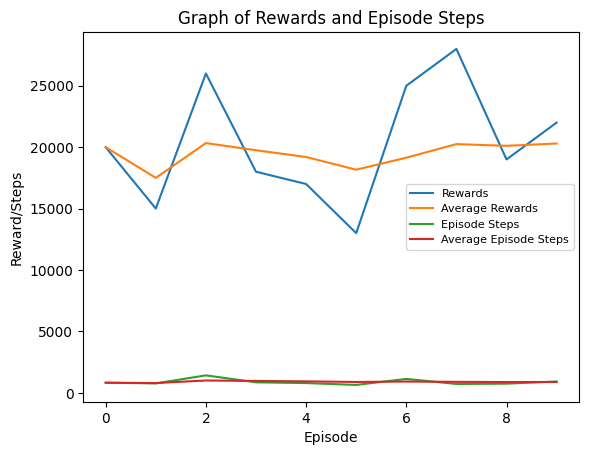

In [3]:
import matplotlib.pyplot as plt

# Calculate the average reward
average_rewards = []
for i in range(len(rewards)):
    average_rewards.append(sum(rewards[:i + 1]) / (i + 1))

# Calculate the average steps
average_steps = []
for i in range(len(steps)):
    average_steps.append(sum(steps[:i + 1]) / (i + 1))

# Create the plot axes
fig, ax = plt.subplots()

# Plot the rewards
ax.plot(rewards, label="Rewards")
ax.plot(average_rewards, label="Average Rewards")

# Plot the episode steps
ax.plot(steps, label="Episode Steps")
ax.plot(average_steps, label="Average Episode Steps")

# Add a legend to the plot
ax.legend(prop={'size': 8})

# Add a title to the plot
ax.set_title("Graph of Rewards and Episode Steps")

# Add labels to the axes
ax.set_xlabel("Episode")
ax.set_ylabel("Reward/Steps")

# Show the plot
plt.show()


In [10]:
resultados = pd.DataFrame(dqn.history)

print("Average: ", round(resultados['episode_reward'].mean(),2))


Average Reward:  20.3


## 3) Justificación de los parámetros seleccionados y de los resultados obtenidos

Gracias a la combinación de Redes Neuronales con el algoritmo Q-learning, conseguimos clasificar los mejores pares acción-estado para cada estado.

La clave dentro del algoritmo ha sido la selección de políticas de exploración e-greedy, donde los valores de epsilon-greedy son:

value_max: 1.0
value_min: 0.1
value_test: 0.05
nb_steps: 750000

El valor de epsilon se reducirá de 1.0 a 0.1 a lo largo de 750.000 pasos. Hemos encontrado que con este hiperparámetro, el algoritmo juega bien y llega al objetivo esperado. Aún así, con más capacidad computacional, no descartamos utilizar un e-greedy con un mayor número de pasos (2000000 por ejemplo), que nos podría permitir una bajada más gtadual de epsilon, pudiendo encontrar otros detalles dentro del juego (Como por ejemplo podría ser el uso/ no uso eficiente) de las islas. 





También observamos que los valores de entrenamiento son muy variables, obteniendo "máximos" de rewards bastante elevados en comparación a la media total. Tenemos bastante variabilidad en el algoritmo en ese sentido.

In [ ]:
Interval 66 (650000 steps performed)
10000/10000 [==============================] - 326s 33ms/step - reward: 0.0145
10 episodes - episode_reward: 15.000 [5.000, 30.000] - loss: 0.008 - mae: 1.003 - mean_q: 1.209 - mean_eps: 0.214 - ale.lives: 2.173

Por último, mencionar que la arquitectura de nuestro modelo consta de 2,188,854 parámetros entrenables.  Creemos que el número de parámetros utilizados es suficiente para el juego de "Space Invaders". Pero quizá la arquitectura de el agente y del target net podría ser revisada.

**Model: "sequential_2"**

 permute_2 (Permute)         (None, 84, 84, 4)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 80, 80, 16)        1616      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 38, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 19, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               2097664   
                                                                 
Trainable params: 2,188,854
Non-trainable params: 0

## 4) Conclusiones

**Para este proyecto, utilizamos las librerias de tensorflow y keras rl, probando en el camino a crear la arquitectura del modelo por clases con pytorch.**

**Al igual que el feedback de la asignatura de Matemáticas para la Inteligencia Artificial fue muy positivo ya que entendíamos en profundidad como utilizar las distintas técnicas que se usan en Inteligencia Artificial, diríamos que este proyecto a resultado ser mucho más pesado y dificil y que tenemos la sensación de que el aprendizaje ha sido menor.**

Esto se debe principalmente a que las liberías de rl y tensorflow tienen problemas de compatibilidad, con los que hemos estado mas tiempo lidiando con errores entre librerias, que realizando y diseñando el proyecto. También hemos tenido problemas de entrenamiento (por la capacidad de colab) y hasta que porfin el notebook ha corrido entero, hemos tenido que probar alrededor de 15-16 veces. Como alumnos, creemos que aportaría mas entrenar un modelo desde 0 entendiendo su arquitectura aunque sea mucho más simple que intentar usar liberias empaquetadas con problemas de compatibilidad.

Por el resto, las clases nos han parecido buenas y la asignatura completa para entender el mundo de RL.

## 5)  Anexo de Experimentos. Modelo desde 0

**Antes de conseguir llegar al objetivo mediante el uso de RL de keras. Hemos intentado aplicar una arquitectura desde 0 con la liberia pytorch.**

Conseguimos entrenar un modelo que llega a los 320 puntos en alguna partida, pero nos quedamos atascados cuando creemos que la memoria no nos está funcionando bien.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class DQNNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        # Assuming the network has two convolutional layers, followed by fully connected layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(8, 10), stride=4)  # Modified kernel size to handle 210x160 input
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.fc1 = nn.Linear(27648, 128)  # Adjusted output shape based on modified kernel size
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 27648) # Modified view() operation to match adjusted output shape
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [18]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

INPUT_SHAPE = (210, 160)
WINDOW_LENGTH = 4

env_name = 'SpaceInvaders-v4'
env = gym.make(env_name) #render_mode='human')

np.random.seed(123)
nb_actions = env.action_space.n
state, info = env.reset()

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, reward, next_state, done))
        else:
            # When memory is full, start replacing samples randomly
            random_index = np.random.randint(0, self.capacity)
            self.memory[random_index] = (state, action, reward, next_state, done)

        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        samples = np.random.choice(len(self.memory), batch_size, replace=False) ## Ojo, quizá merece la pena aquí hacer un replace = False y sustituir con lo que haya.
        return [self.memory[i] for i in samples]

class DQNAgent(object):
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.net = DQNNet(state_dim, action_dim)
        self.target_net = DQNNet(state_dim, action_dim)
        self.target_net.load_state_dict(self.net.state_dict())

        self.optimizer = optim.Adam(self.net.parameters())
        self.loss_fn = nn.MSELoss()

        self.replay_memory = ReplayMemory(10000)

    def update(self, batch_size):
        if len(self.replay_memory.memory) < self.replay_memory.capacity:
            # Skip the update if the memory is not full yet
            pass
        else:

            memory_sampling = self.replay_memory.sample(batch_size)

            states = []
            actions = []
            rewards = []
            next_states = []
            dones = []

            for experience in memory_sampling:
                states.append(experience[0])
                actions.append(experience[1])
                rewards.append(experience[2])
                next_states.append(experience[3])
                dones.append(experience[4])

            states = torch.cat(states, dim=0) 
            next_states = torch.cat(next_states, dim=0) 



            # print(actions)
            
            
            i2 = 1
            states = torch.tensor(states[i2]).float().unsqueeze(0)
            actions = torch.tensor(actions[i2]).long().unsqueeze(0)
            rewards = torch.tensor(rewards[i2]).float()
            next_states = torch.tensor(next_states[i2]).float().unsqueeze(0)
            dones = torch.tensor(dones[i2]).float()


            q_values = self.net(states)


            action_indices = torch.arange(6).long().unsqueeze(0)
            

            q_values = q_values.gather(1, action_indices)
      
           

            


            next_q_values = self.target_net(next_states)
            max_next_q_values = torch.max(next_q_values, dim=1).values
            target_q_values = rewards + (0.99 * max_next_q_values) * (1 - dones)


           



            # Calculate loss for the current experience
            loss = self.loss_fn(q_values, target_q_values)

            # Accumulate loss

            

            # print("q_value", q_values, "target", target_q_values )

            # print("Accumulated Loss: ", loss)

            # Perform backpropagation using the accumulated loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def act(self, state):

        
        
        gray_image = np.dot(state[..., :3], [0.2989, 0.5870, 0.1140])
        
        # Normalize pixel values (optional but often done in image processing)
        state = gray_image / 255.0


        
        
        state = torch.tensor(state).float().unsqueeze(0)
    

        

        q_values = self.net(state)
        
        action = torch.argmax(q_values, dim=1).item()

        return action
    

    

agent = DQNAgent(INPUT_SHAPE[0] * WINDOW_LENGTH, nb_actions)
i=0
game_score = []

# Turn Off and On the Enviroment.

# env.render()  

# Ponemos un range pequeño en este notebook para hacer la demostración. En el entrenamiento que hemos intetnado, tenemos más

for episode in range(200):
    state = env.reset()
    total_reward = 0
    
    state= state[0]
    
    i +=1
    print(i)

    for t in range(10000):
        
        
        
        action = agent.act(state)
        results_act = env.step(action)
        next_state = results_act[0]
        reward = results_act[1]
        done = results_act[2]
        _ = results_act[3]
        total_reward += reward

        gray_image = np.dot(state[..., :3], [0.2989, 0.5870, 0.1140])
        state = gray_image / 255.0
        state = torch.tensor(state).float().unsqueeze(0)
        


        gray_image = np.dot(next_state[..., :3], [0.2989, 0.5870, 0.1140])
        next_state_store = gray_image / 255.0
        next_state_store = torch.tensor(state).float()
      
        
        if i > 1:
            agent.replay_memory.push(state, action, reward, next_state_store, done)
            agent.update(32)


        state = next_state
        
        
       

        if done:
            print("Game Over")
            game_score.append(total_reward)
            print("Game_Score", game_score)

            break




1


/var/folders/vz/gbtwmbg50fj0wjbh42bpfh1m0000gn/T/ipykernel_1999/1033777297.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state_store = torch.tensor(state).float()


Game Over
Game_Score [270.0]
2
Game Over
Game_Score [270.0, 270.0]
3
Game Over
Game_Score [270.0, 270.0, 270.0]
4
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0]
5
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0]
6
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0]
7
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0]
8
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0]
9
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0]
10
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0]
11
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0]
12
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0]
13
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0]
14
Game Over
Game_Score [270.0, 270.0, 270.0, 270

/var/folders/vz/gbtwmbg50fj0wjbh42bpfh1m0000gn/T/ipykernel_1999/1033777297.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states[i2]).float().unsqueeze(0)
/var/folders/vz/gbtwmbg50fj0wjbh42bpfh1m0000gn/T/ipykernel_1999/1033777297.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states = torch.tensor(next_states[i2]).float().unsqueeze(0)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size

Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0]
16
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 240.0]
17
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 240.0, 270.0]
18
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 240.0, 270.0, 270.0]
19
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 240.0, 270.0, 270.0, 270.0]
20
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 240.0, 270.0, 270.0, 270.0, 270.0]
21
Game Over
Game_Score [270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 27

KeyboardInterrupt: 